In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import warnings

plt.style.use('seaborn')
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

# Financial Data and Preprocessing 

## Getting data from Quandl 

1. Import the libraries:

In [3]:
!pip install quandl
import pandas as pd 
import quandl

2. Authenticate using the personal API key:

In [4]:
QUANDL_KEY = 'gYbLFzNA6_QknaEz6uEc' # replace {key} with your own API key  
quandl.ApiConfig.api_key = QUANDL_KEY

3. Download the data:

In [5]:
df_quandl = quandl.get(dataset='WIKI/AAPL',
                       start_date='2000-01-01', 
                       end_date='2010-12-31')

4. Inspect the data:

In [6]:
print(f'Downloaded {df_quandl.shape[0]} rows of data.')

df_quandl.head()

Downloaded 2767 rows of data.


Open    High     Low   Close     Volume  Ex-Dividend  \
Date                                                                 
2000-01-03  104.87  112.50  101.69  111.94  4783900.0          0.0   
2000-01-04  108.25  110.62  101.19  102.50  4574800.0          0.0   
2000-01-05  103.75  110.56  103.00  104.00  6949300.0          0.0   
2000-01-06  106.12  107.00   95.00   95.00  6856900.0          0.0   
2000-01-07   96.50  101.00   95.50   99.50  4113700.0          0.0   

            Split Ratio  Adj. Open  Adj. High  Adj. Low  Adj. Close  \
Date                                                                  
2000-01-03          1.0   3.369314   3.614454  3.267146    3.596463   
2000-01-04          1.0   3.477908   3.554053  3.251081    3.293170   
2000-01-05          1.0   3.333330   3.552125  3.309234    3.341362   
2000-01-06          1.0   3.409475   3.437748  3.052206    3.052206   
2000-01-07          1.0   3.100399   3.244977  3.068270    3.196784   

            Adj. Volume  
Date                     
2000-01-03  133949200.0  
2000-01-04  128094400.0  
2000-01-05  194580400.0  
2000-01-06  191993200.0  
2000-01-07  115183600.0

## Converting prices to returns

### How to do it...

1. Import the libraries:

In [7]:
import pandas as pd 
import numpy as np 
!pip install yfinance
import yfinance as yf

2. Download the data and keep the adjusted close prices only:

In [8]:
df = yf.download('AAPL', 
                 start='1999-12-31', 
                 end='2010-12-31',
                 progress=False)

df = df.loc[:, ['Adj Close']]
df.rename(columns={'Adj Close':'adj_close'}, inplace = True)

3. Convert adjusted close prices to simple and log returns:

In [9]:
df['simple_rtn'] = df.adj_close.pct_change()
df['log_rtn'] = np.log(df.adj_close/df.adj_close.shift(1))

4. Inspect the output:

In [10]:
df.head()

adj_close  simple_rtn   log_rtn
Date                                       
1999-12-30   0.764732         NaN       NaN
1999-12-31   0.783791    0.024923  0.024617
2000-01-03   0.853355    0.088753  0.085033
2000-01-04   0.781409   -0.084310 -0.088077
2000-01-05   0.792843    0.014633  0.014527

### There's more

1. Import libraries and authenticate:

In [11]:
import pandas as pd
import quandl

QUANDL_KEY = 'gYbLFzNA6_QknaEz6uEc' # replace {key} with your own API key  
quandl.ApiConfig.api_key = QUANDL_KEY

2. Create a DataFrame with all possible dates and left join the prices on it:

In [12]:
df_all_dates = pd.DataFrame(index=pd.date_range(start='1999-12-31', 
                                                end='2010-12-31'))
df = df_all_dates.join(df[['adj_close']], how='left').fillna(method='ffill').asfreq('M')

3. Download inflation data from Quandl:

In [13]:
df_cpi = quandl.get(dataset='RATEINF/CPI_USA', 
                    start_date='1999-12-31', 
                    end_date='2010-12-31')
df_cpi.rename(columns={'Value':'cpi'}, inplace=True)
df_cpi.head(5)

cpi
Date             
1999-12-31  168.3
2000-01-31  168.8
2000-02-29  169.8
2000-03-31  171.2
2000-04-30  171.3

4. Merge inflation data to prices:

In [14]:
df_merged = df.join(df_cpi, how='left')
df_merged.head(5)

adj_close    cpi
1999-12-31   0.783791  168.3
2000-01-31   0.790938  168.8
2000-02-29   0.873844  169.8
2000-03-31   1.035367  171.2
2000-04-30   0.945791  171.3

5. Calculate simple returns and inflation rate:

In [15]:
df_merged['simple_rtn'] = df_merged.adj_close.pct_change()
df_merged['inflation_rate'] = df_merged.cpi.pct_change()

6. Adjust returns for inflation:

In [16]:
df_merged['real_rtn'] = (df_merged.simple_rtn + 1) / (df_merged.inflation_rate + 1) - 1
df_merged.head()

adj_close    cpi  simple_rtn  inflation_rate  real_rtn
1999-12-31   0.783791  168.3         NaN             NaN       NaN
2000-01-31   0.790938  168.8    0.009118        0.002971  0.006129
2000-02-29   0.873844  169.8    0.104820        0.005924  0.098314
2000-03-31   1.035367  171.2    0.184842        0.008245  0.175152
2000-04-30   0.945791  171.3   -0.086516        0.000584 -0.087050

## Changing frequency

0. Obtain the simple returns in case of starting in this recipe:

In [17]:
import pandas as pd 
import yfinance as yf

# download data 
df = yf.download('AAPL', 
                 start='2000-01-01', 
                 end='2010-12-31', 
                 auto_adjust=False,
                 progress=False)

# keep only the adjusted close price
df = df.loc[:, ['Adj Close']]
df.rename(columns={'Adj Close':'adj_close'}, inplace=True)

# calculate simple returns
df['log_rtn'] = np.log(df.adj_close/df.adj_close.shift(1))

# remove redundant data
df.drop('adj_close', axis = 1, inplace=True)
df.dropna(axis=0, inplace=True)

df.head()

log_rtn
Date                
2000-01-03  0.085033
2000-01-04 -0.088077
2000-01-05  0.014527
2000-01-06 -0.090514
2000-01-07  0.046281

1. Import the libraries:

In [18]:
import pandas as pd 

2. Define the function for calculating the realized volatility:

In [19]:
def realized_volatility(x): 
    return np.sqrt(np.sum(x**2))

3. Calculate monthly realized volatility:

In [20]:
df_rv = df.groupby(pd.Grouper(freq='M')).apply(realized_volatility)
df_rv.rename(columns={'log_rtn':'rv'}, inplace =True) 

4. Annualize the values:

In [21]:
df_rv.rv = df_rv.rv * np.sqrt(12)

5. Plot the results:

<function matplotlib.pyplot.show(close=None, block=None)>

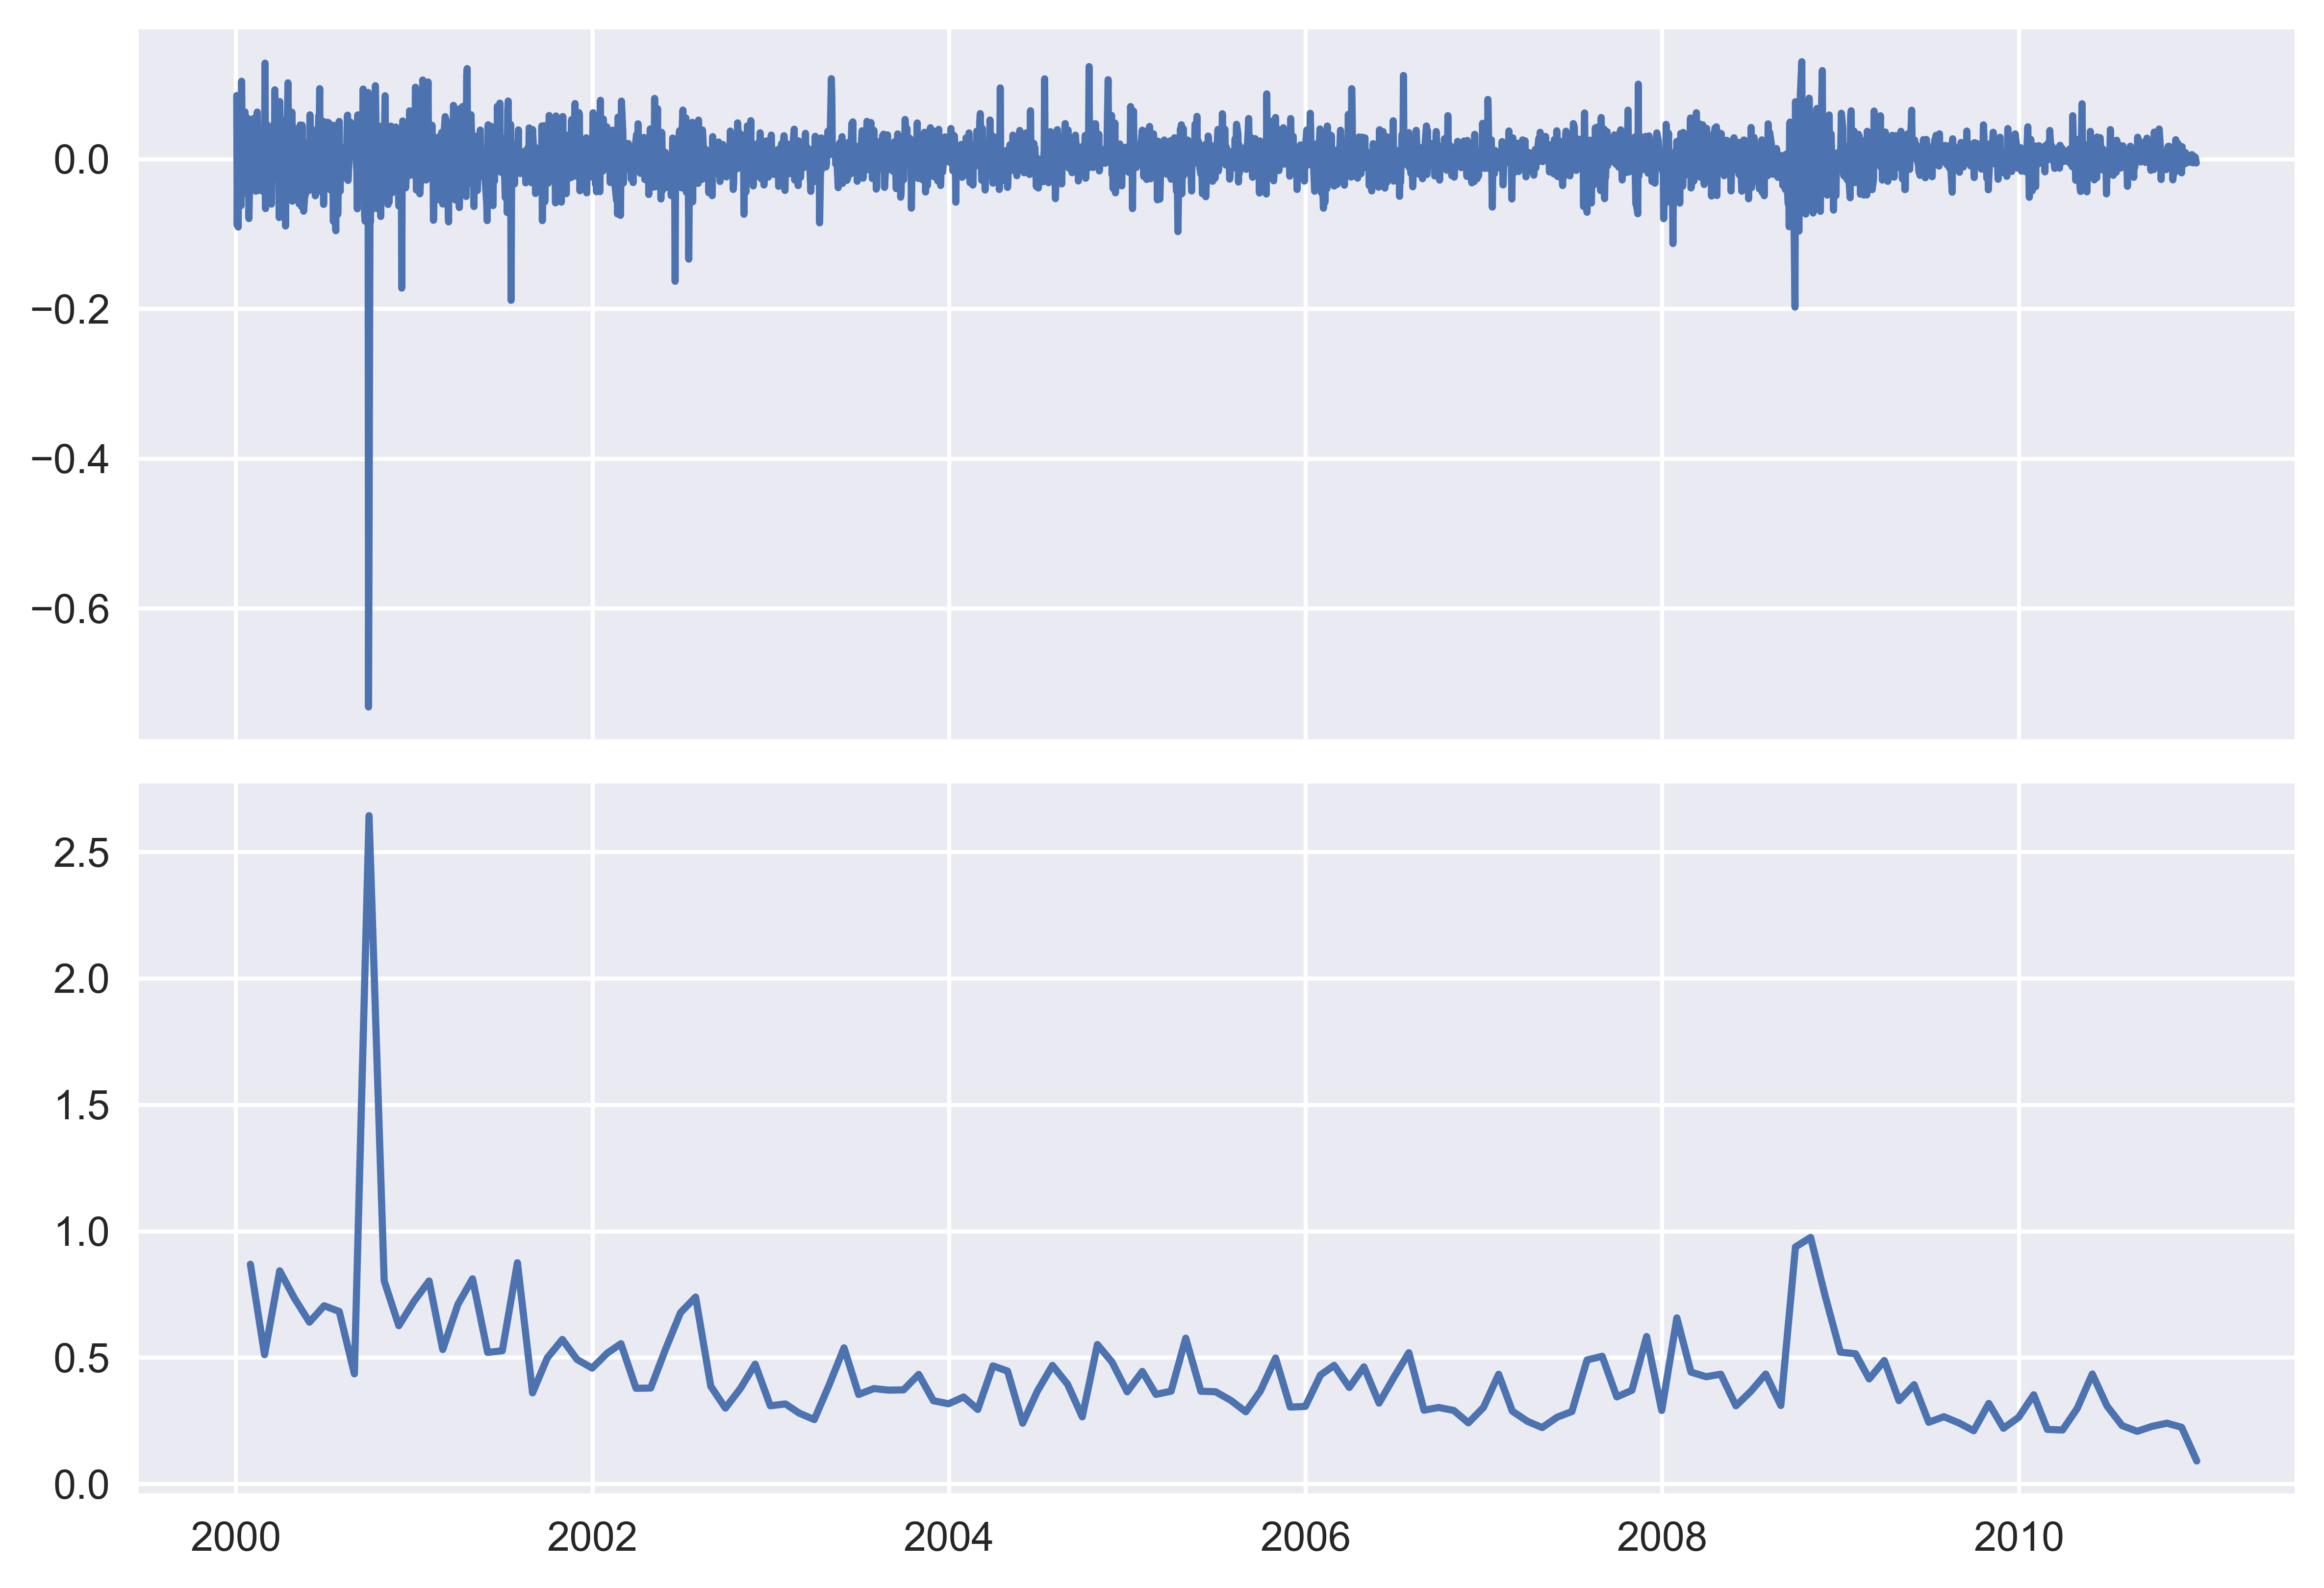

In [22]:
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(df)
ax[1].plot(df_rv)

plt.tight_layout()
# plt.savefig('image/ch1.png')
plt.show

## Visualizing time series data

### Getting ready

In [23]:
import pandas as pd 
import yfinance as yf

# download data as pandas DataFrame
df = yf.download('MSFT', auto_adjust = False, progress=False)
df = df.loc[:, ['Adj Close']]
df.rename(columns={'Adj Close': 'adj_close'}, inplace=True)

# create simple and log returns
df['simple_rtn'] = df.adj_close.pct_change()
df['log_rtn'] = np.log(df.adj_close / df.adj_close.shift(1))

# dropping NA's in the first row
df.dropna(how = 'any', inplace = True)

### How to do it...

#### the `plot` method of pandas

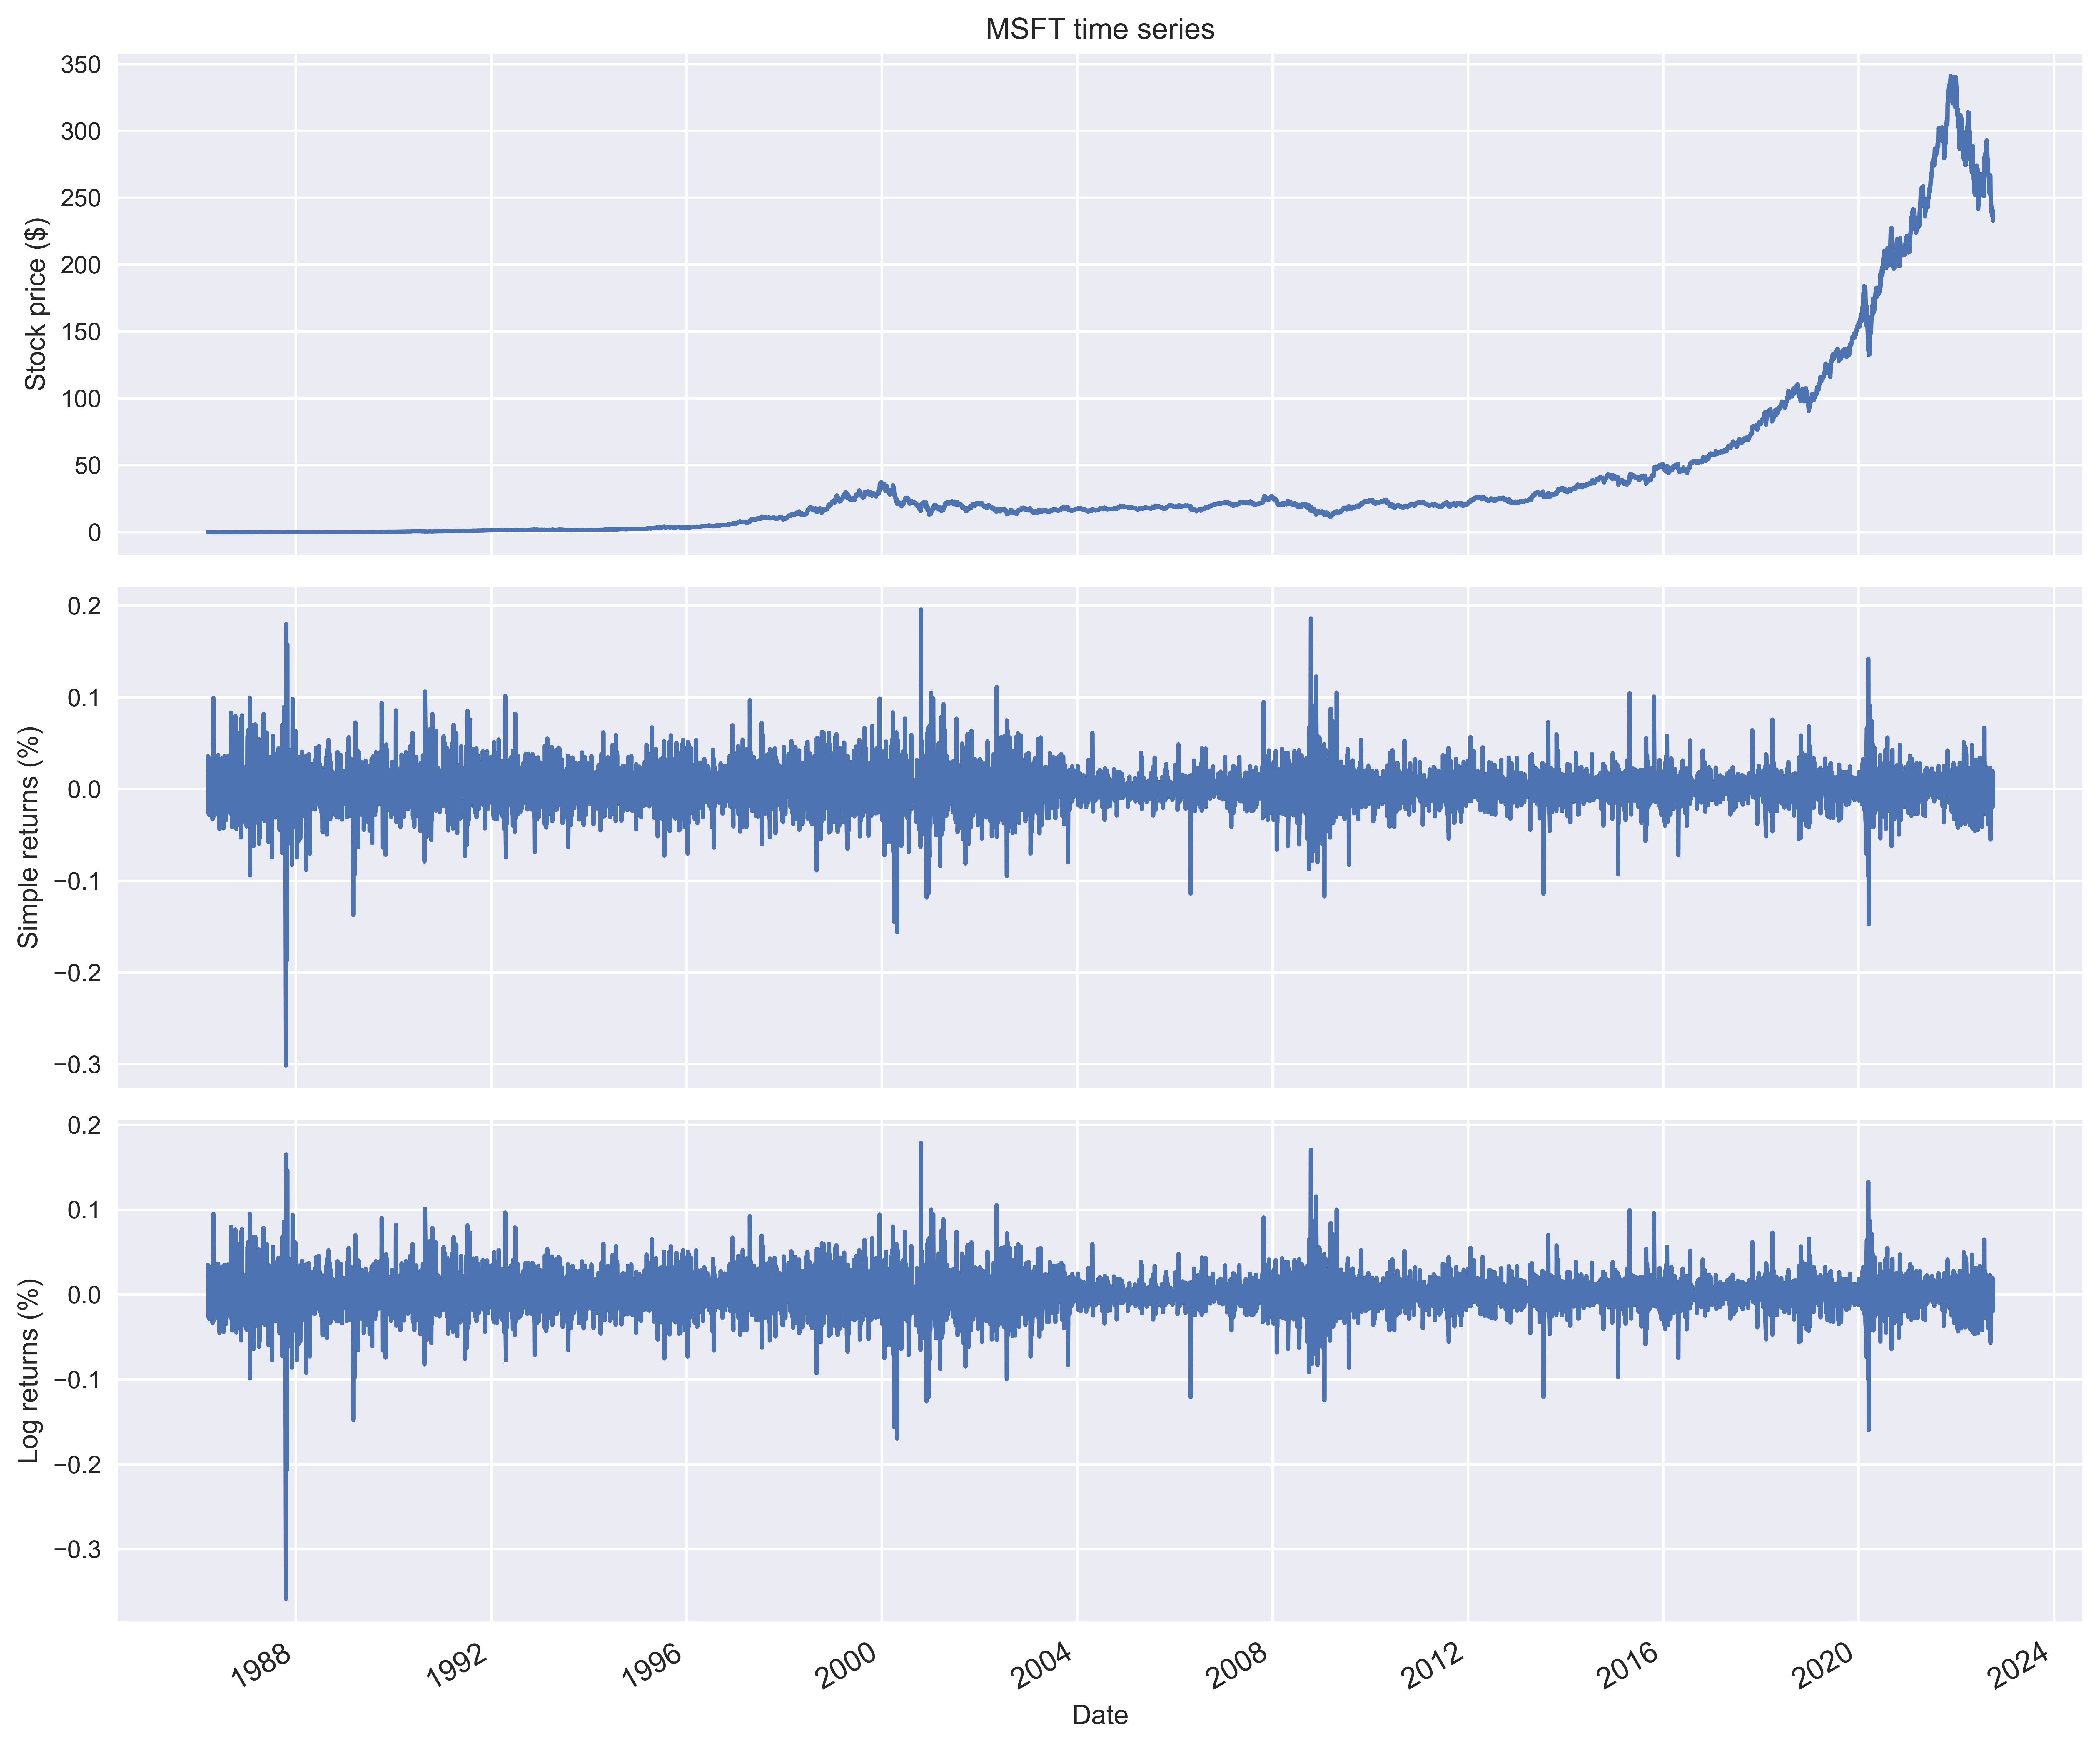

In [24]:
fig, ax = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# add prices
df.adj_close.plot(ax=ax[0])
ax[0].set(title = 'MSFT time series', 
          ylabel = 'Stock price ($)')

# add simple returns 
df.simple_rtn.plot(ax=ax[1])
ax[1].set(ylabel = 'Simple returns (%)')

# add log returns 
df.log_rtn.plot(ax=ax[2])
ax[2].set(xlabel = 'Date', 
          ylabel = 'Log returns (%)')

ax[2].tick_params(axis='x', 
                  which='major', 
                  labelsize=12)
plt.tight_layout()
plt.show()

## Identifying outliers

0: Repeat the steps from recipe *Converting prices to returns*:

In [25]:
import pandas as pd 
import yfinance as yf

In [26]:
df = yf.download('AAPL', 
                 start='2000-01-01', 
                 end='2010-12-31',
                 progress=False)

df = df.loc[:, ['Adj Close']]
df.rename(columns={'Adj Close':'adj_close'}, inplace=True)

In [27]:
df['simple_rtn'] = df.adj_close.pct_change()

In [28]:
df.head()

adj_close  simple_rtn
Date                             
1999-12-31   0.783791         NaN
2000-01-03   0.853355    0.088754
2000-01-04   0.781409   -0.084310
2000-01-05   0.792843    0.014633
2000-01-06   0.724232   -0.086538

1. Calculate the rolling mean and standard deviation:

In [29]:
df_rolling = df[['simple_rtn']].rolling(window=21).agg(['mean', 'std'])
df_rolling.columns = df_rolling.columns.droplevel()

2. Join the rolling metrics to the original data:

In [30]:
df_outliers = df.join(df_rolling) 

3. Define a function for detecting outliers:

In [31]:
def identify_outliers(row, n_sigmas=3):
    '''
    Function for identifying the outliers using the 3 sigma rule. 
    The row must contain the following columns/indices: simple_rtn, mean, std.
    
    Parameters
    ----------
    row : pd.Series
        A row of a pd.DataFrame, over which the function can be applied.
    n_sigmas : int
        The number of standard deviations above/below the mean - used for detecting outliers
        
    Returns
    -------
    0/1 : int
        An integer with 1 indicating an outlier and 0 otherwise.
    '''
    x = row['simple_rtn']
    mu = row['mean']
    sigma = row['std']

    if (x > mu  + 3 * sigma)  |  (x < mu - 3* sigma): 
        return 1 
    else: 
        return 0 

4. Identify the outliers and extract their values for later use:

In [32]:
df_outliers['outlier'] = df_outliers.apply(identify_outliers, 
                                           axis=1)
outliers = df_outliers.loc[df_outliers['outlier'] == 1, 
                           ['simple_rtn']]

5. Plot the results: 

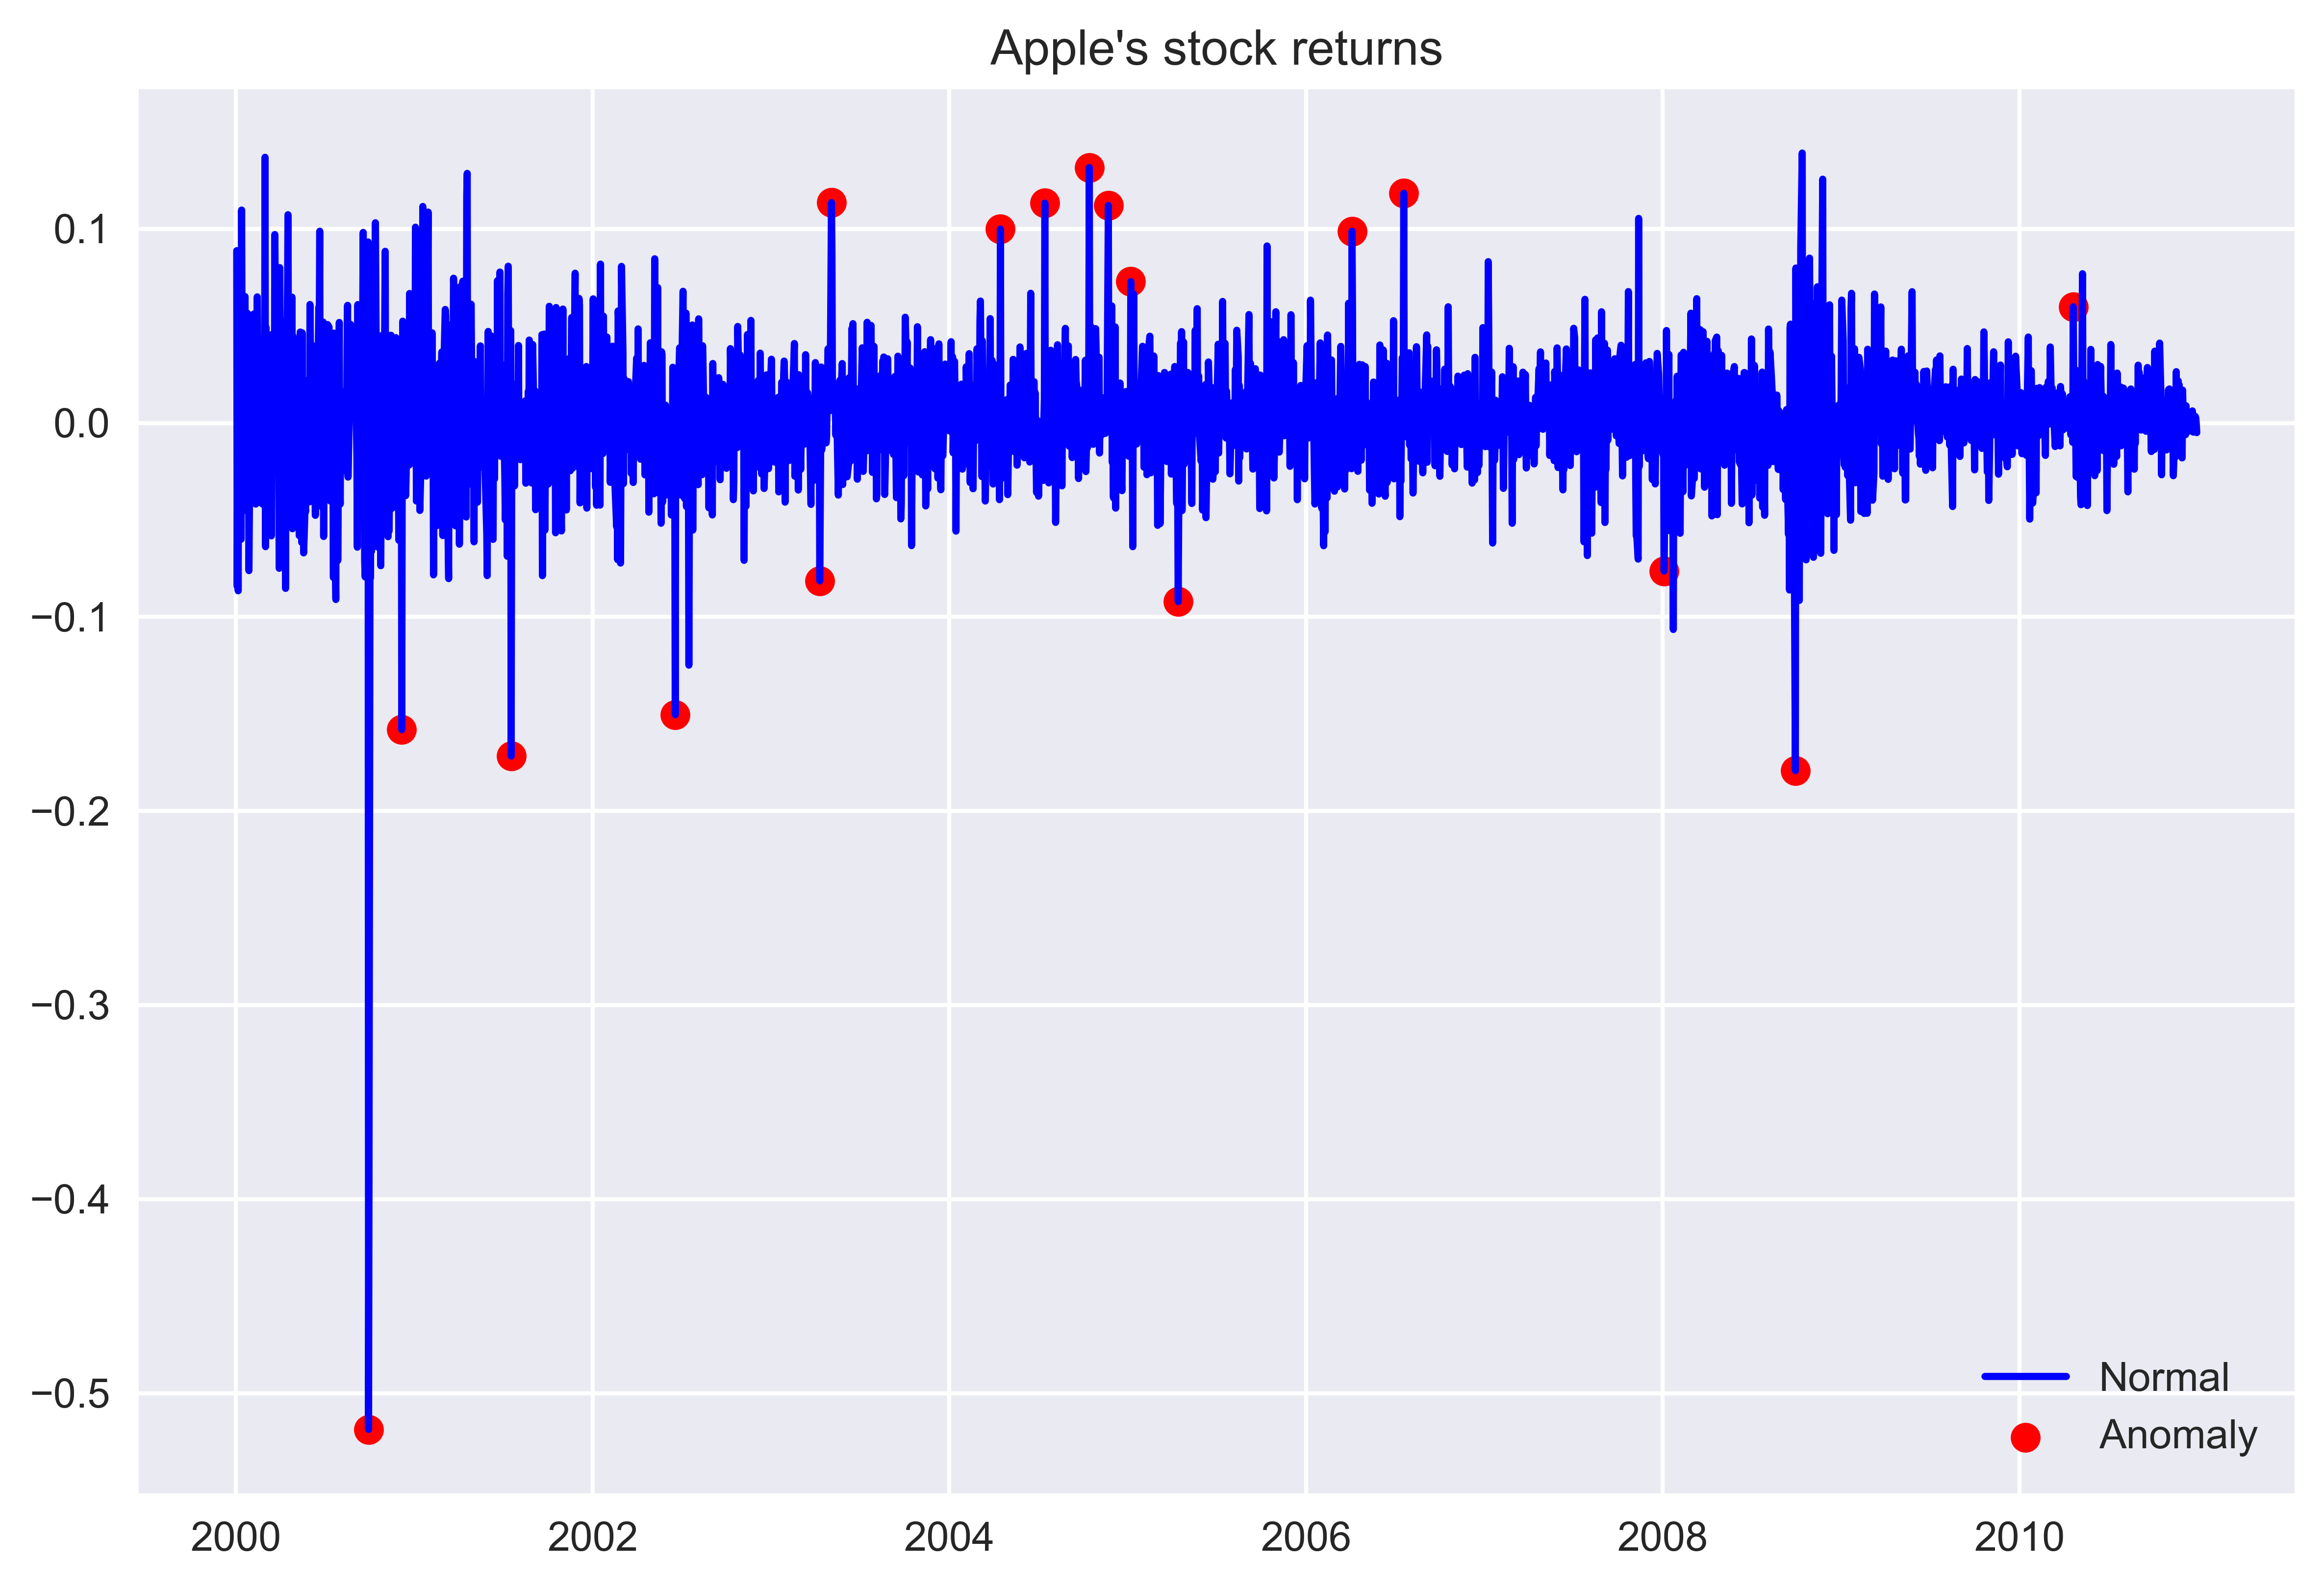

In [33]:
fig, ax = plt.subplots()

ax.plot(df_outliers.index, df_outliers.simple_rtn, 
        color='blue', label='Normal')
ax.scatter(outliers.index, outliers.simple_rtn, 
           color='red', label='Anomaly')
ax.set_title("Apple's stock returns")
ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

## Investigating stylized facts of asset returns

### How to do it...

1. Import the libraries:

In [34]:
import pandas as pd 
import numpy as np
import yfinance as yf
import seaborn as sns 
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.tsa.api as smt

2. Download the S&P 500 data and calculate the returns:

In [35]:
df = yf.download('^GSPC', 
                 start = '1985-01-01', 
                 end='2018-12-31', 
                 progress=False)

df = df[['Adj Close']].rename(columns={'Adj Close': 'adj_close'})
df['log_rtn'] = np.log(df.adj_close/df.adj_close.shift(1))
df = df[['adj_close', 'log_rtn']].dropna(how = 'any')

#### Fact 1 - Non-Gaussian distribution of returns

1. Calculate the Normal PDF using the mean and standard deviation of the observed returns:

In [36]:
r_range = np.linspace(min(df.log_rtn), max(df.log_rtn), num=1000)
mu = df.log_rtn.mean()
sigma = df.log_rtn.std()
norm_pdf = scs.norm.pdf(r_range, loc=mu, scale=sigma)

2. Plot the histogram and the Q-Q Plot:

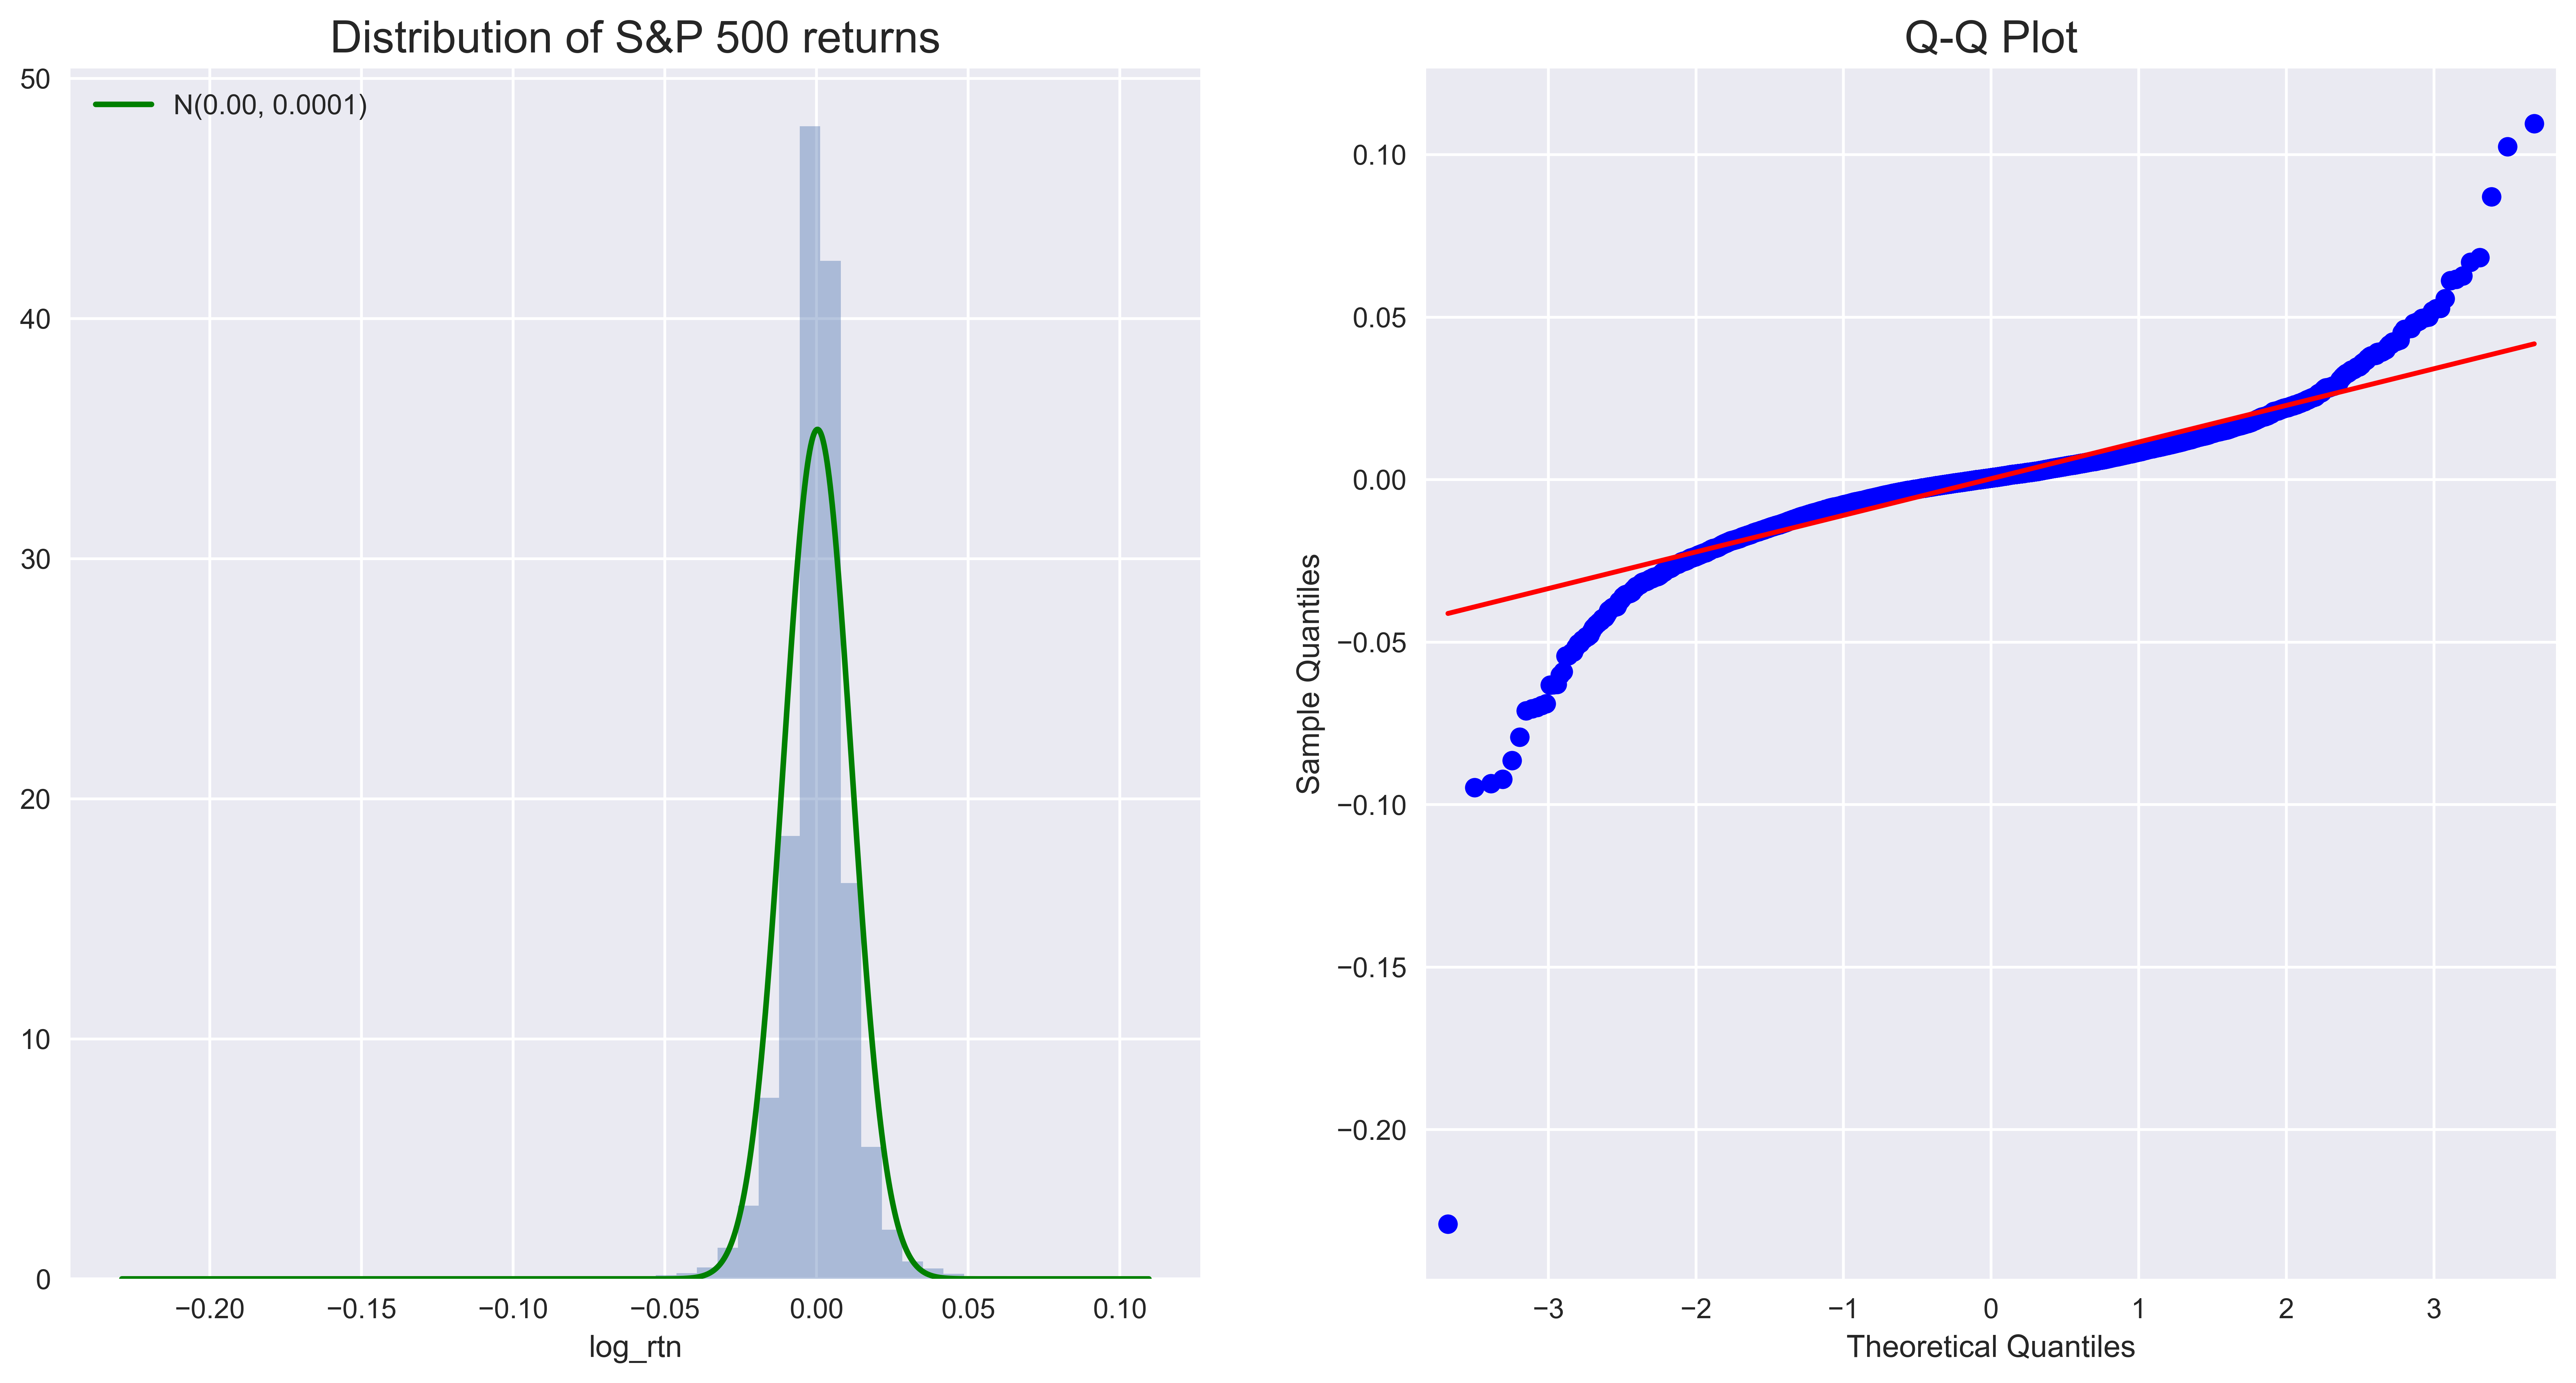

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# histogram
sns.distplot(df.log_rtn, kde=False, norm_hist=True, ax=ax[0])     
ax[0].set_title('Distribution of S&P 500 returns', fontsize=16)  
ax[0].plot(r_range, norm_pdf, 'g', lw=2, 
           label=f'N({mu:.2f}, {sigma**2:.4f})')
ax[0].legend(loc='upper left');                               

# Q-Q plot
qq = sm.qqplot(df.log_rtn.values, line='s', ax = ax[1])
ax[1].set_title('Q-Q Plot', fontsize = 16)

#plt.tight_layout()
plt.show()

3. Print the summary statistics of the log returns:

In [38]:
jb_test = scs.jarque_bera(df.log_rtn.values)

print('---------------Descriptive Statistics------------------')
print('Range of dates:', min(df.index.date), '-', max(df.index.date))
print('Number of observations:', df.shape[0])
print(f'Mean: {df.log_rtn.mean():.4f}')
print(f'Median: {df.log_rtn.median():.4f}')
print(f'Min: {df.log_rtn.min():.4f}')
print(f'Max: {df.log_rtn.max():.4f}')
print(f'Standard Deviation: {df.log_rtn.std():.4f}')
print(f'Skewness: {df.log_rtn.skew():.4f}')
print(f'Kurtosis: {df.log_rtn.kurtosis():.4f}') 
print(f'Jarque-Bera statistic: {jb_test[0]:.2f} with p-value: {jb_test[1]:.2f}')


---------------Descriptive Statistics------------------
Range of dates: 1985-01-02 - 2018-12-28
Number of observations: 8569
Mean: 0.0003
Median: 0.0006
Min: -0.2290
Max: 0.1096
Standard Deviation: 0.0113
Skewness: -1.2624
Kurtosis: 28.0111
Jarque-Bera statistic: 282076.61 with p-value: 0.00


#### Fact 2 - Volatility Clustering

1. Run the following code to visualize the log returns series:

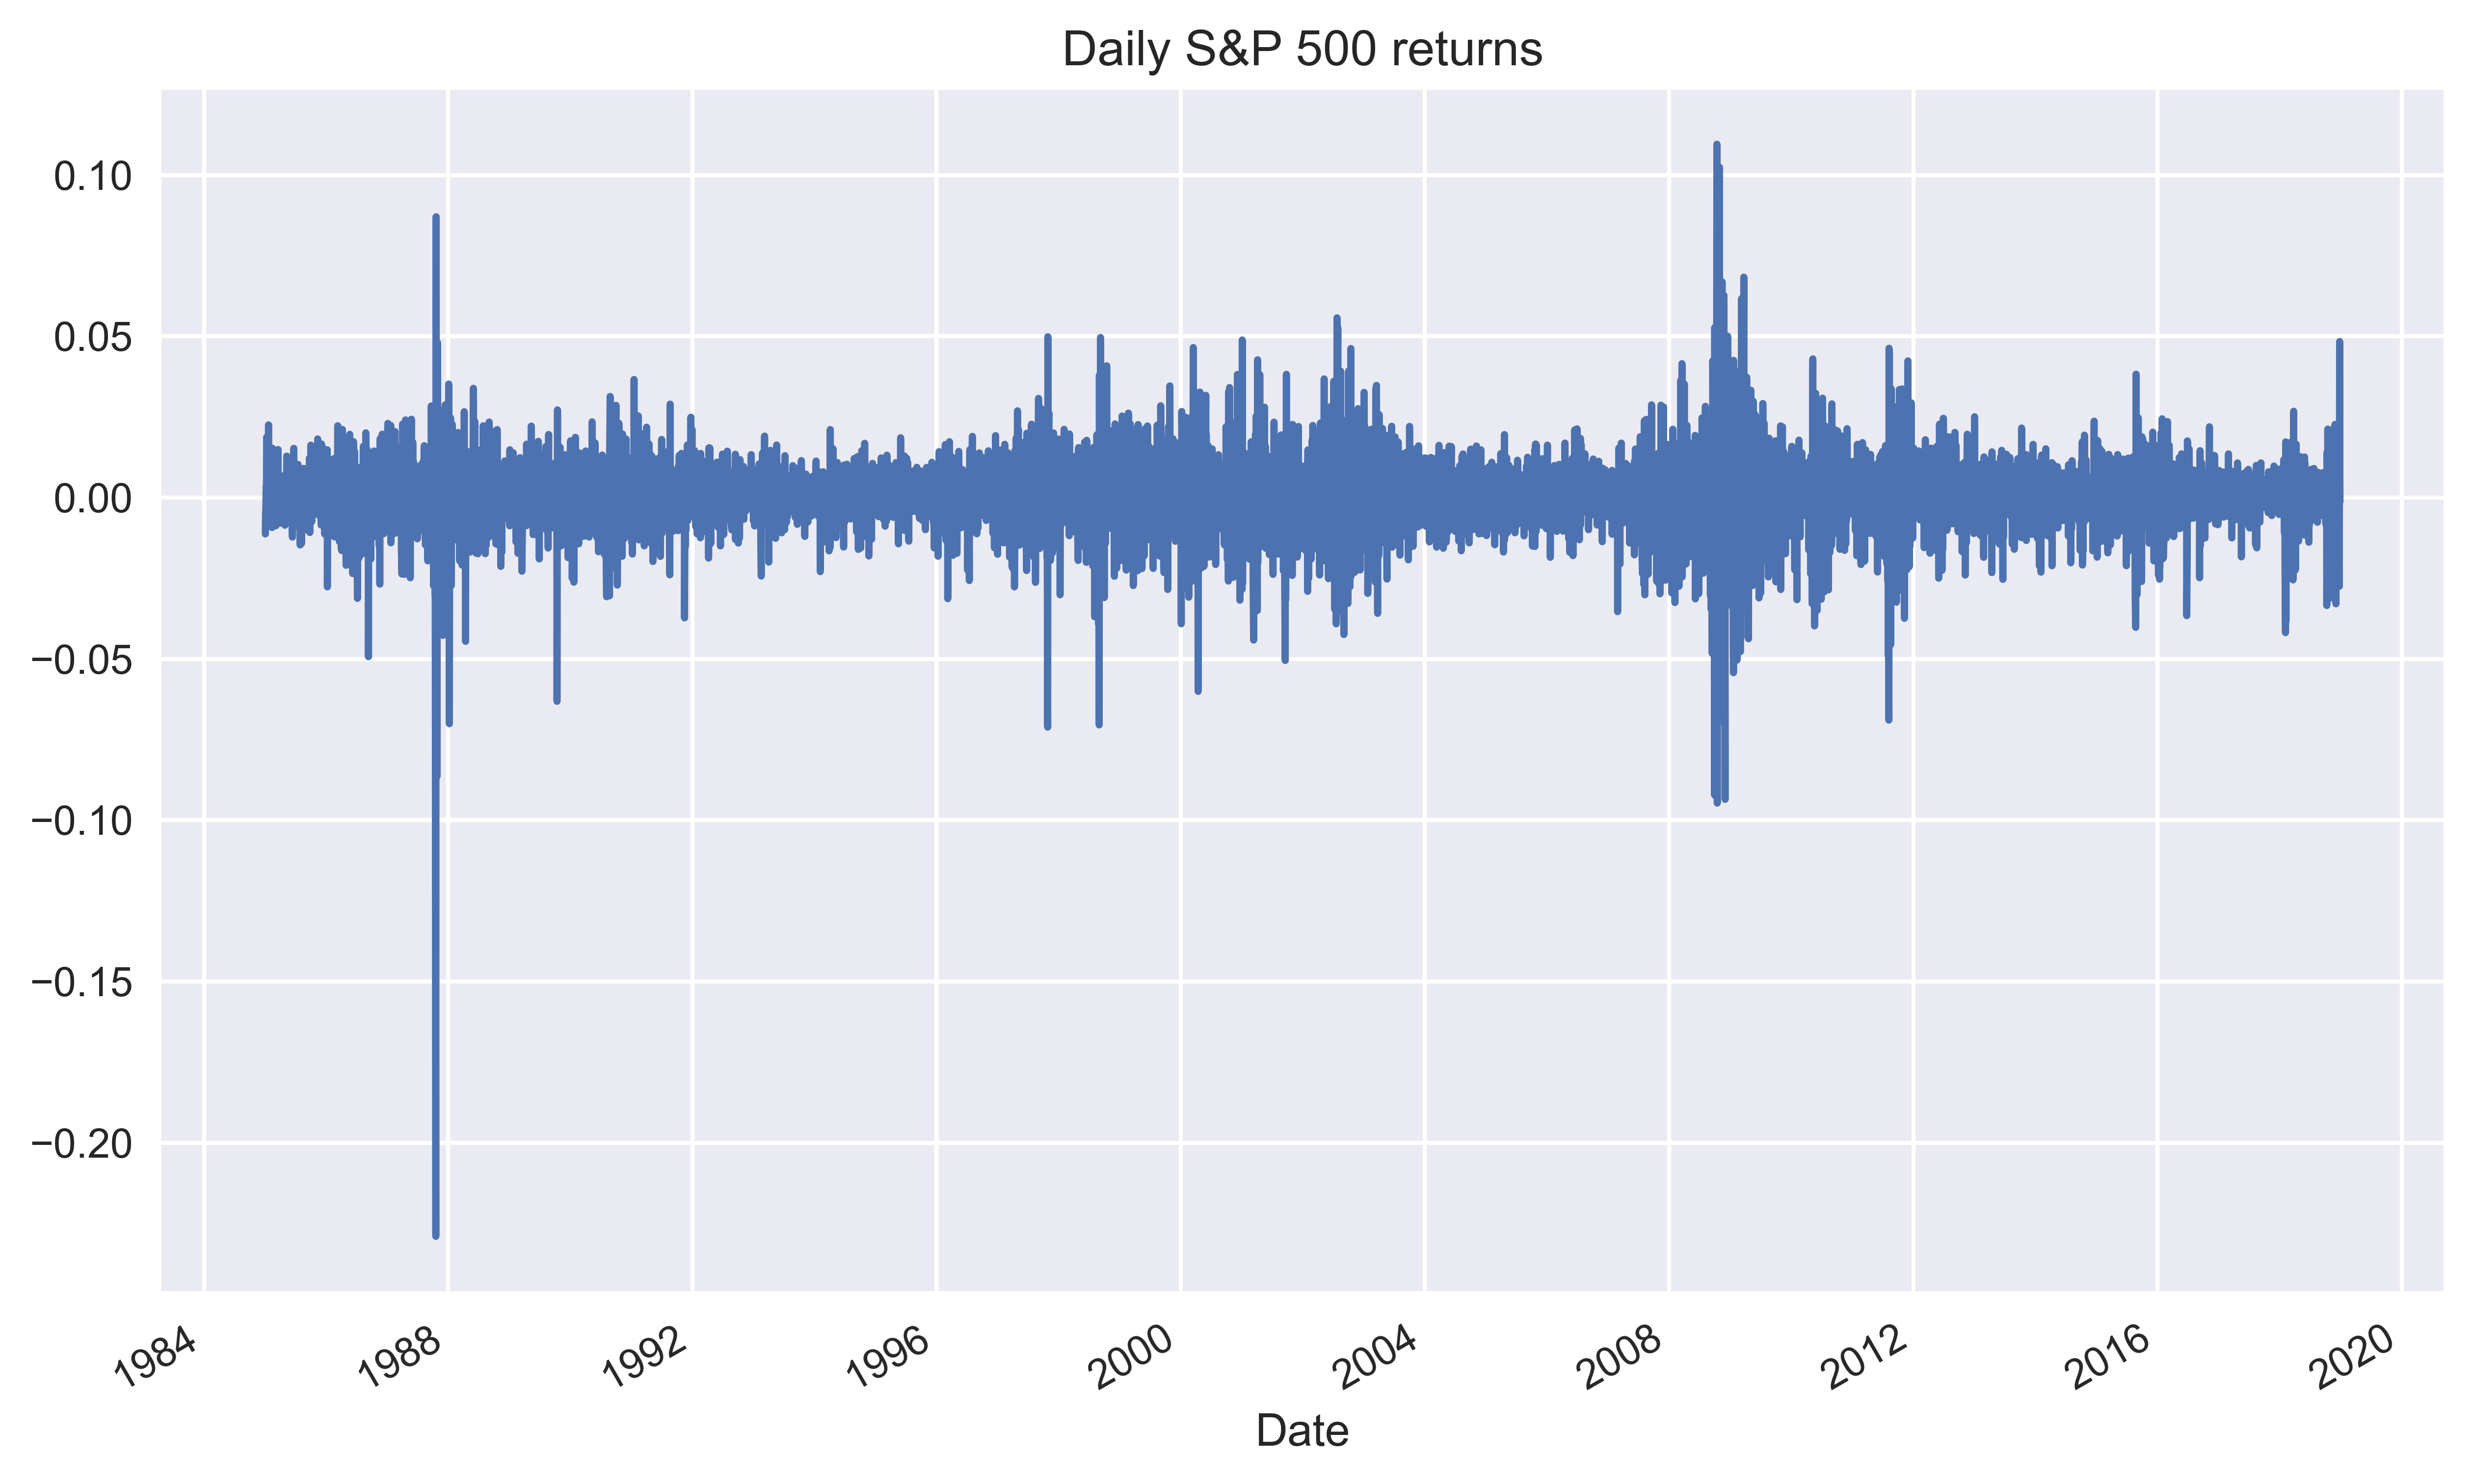

In [39]:
df.log_rtn.plot(title='Daily S&P 500 returns', figsize=(10, 6))

# plt.tight_layout()
# plt.savefig('images/ch1_im12.png')
plt.show()

#### Fact 3 - Absence of autocorrelation in returns

1. Define the parameters for creating the Autocorrelation plots:

In [40]:
N_LAGS = 50
SIGNIFICANCE_LEVEL = 0.05

2. Run the following code to create ACF plot of log returns:

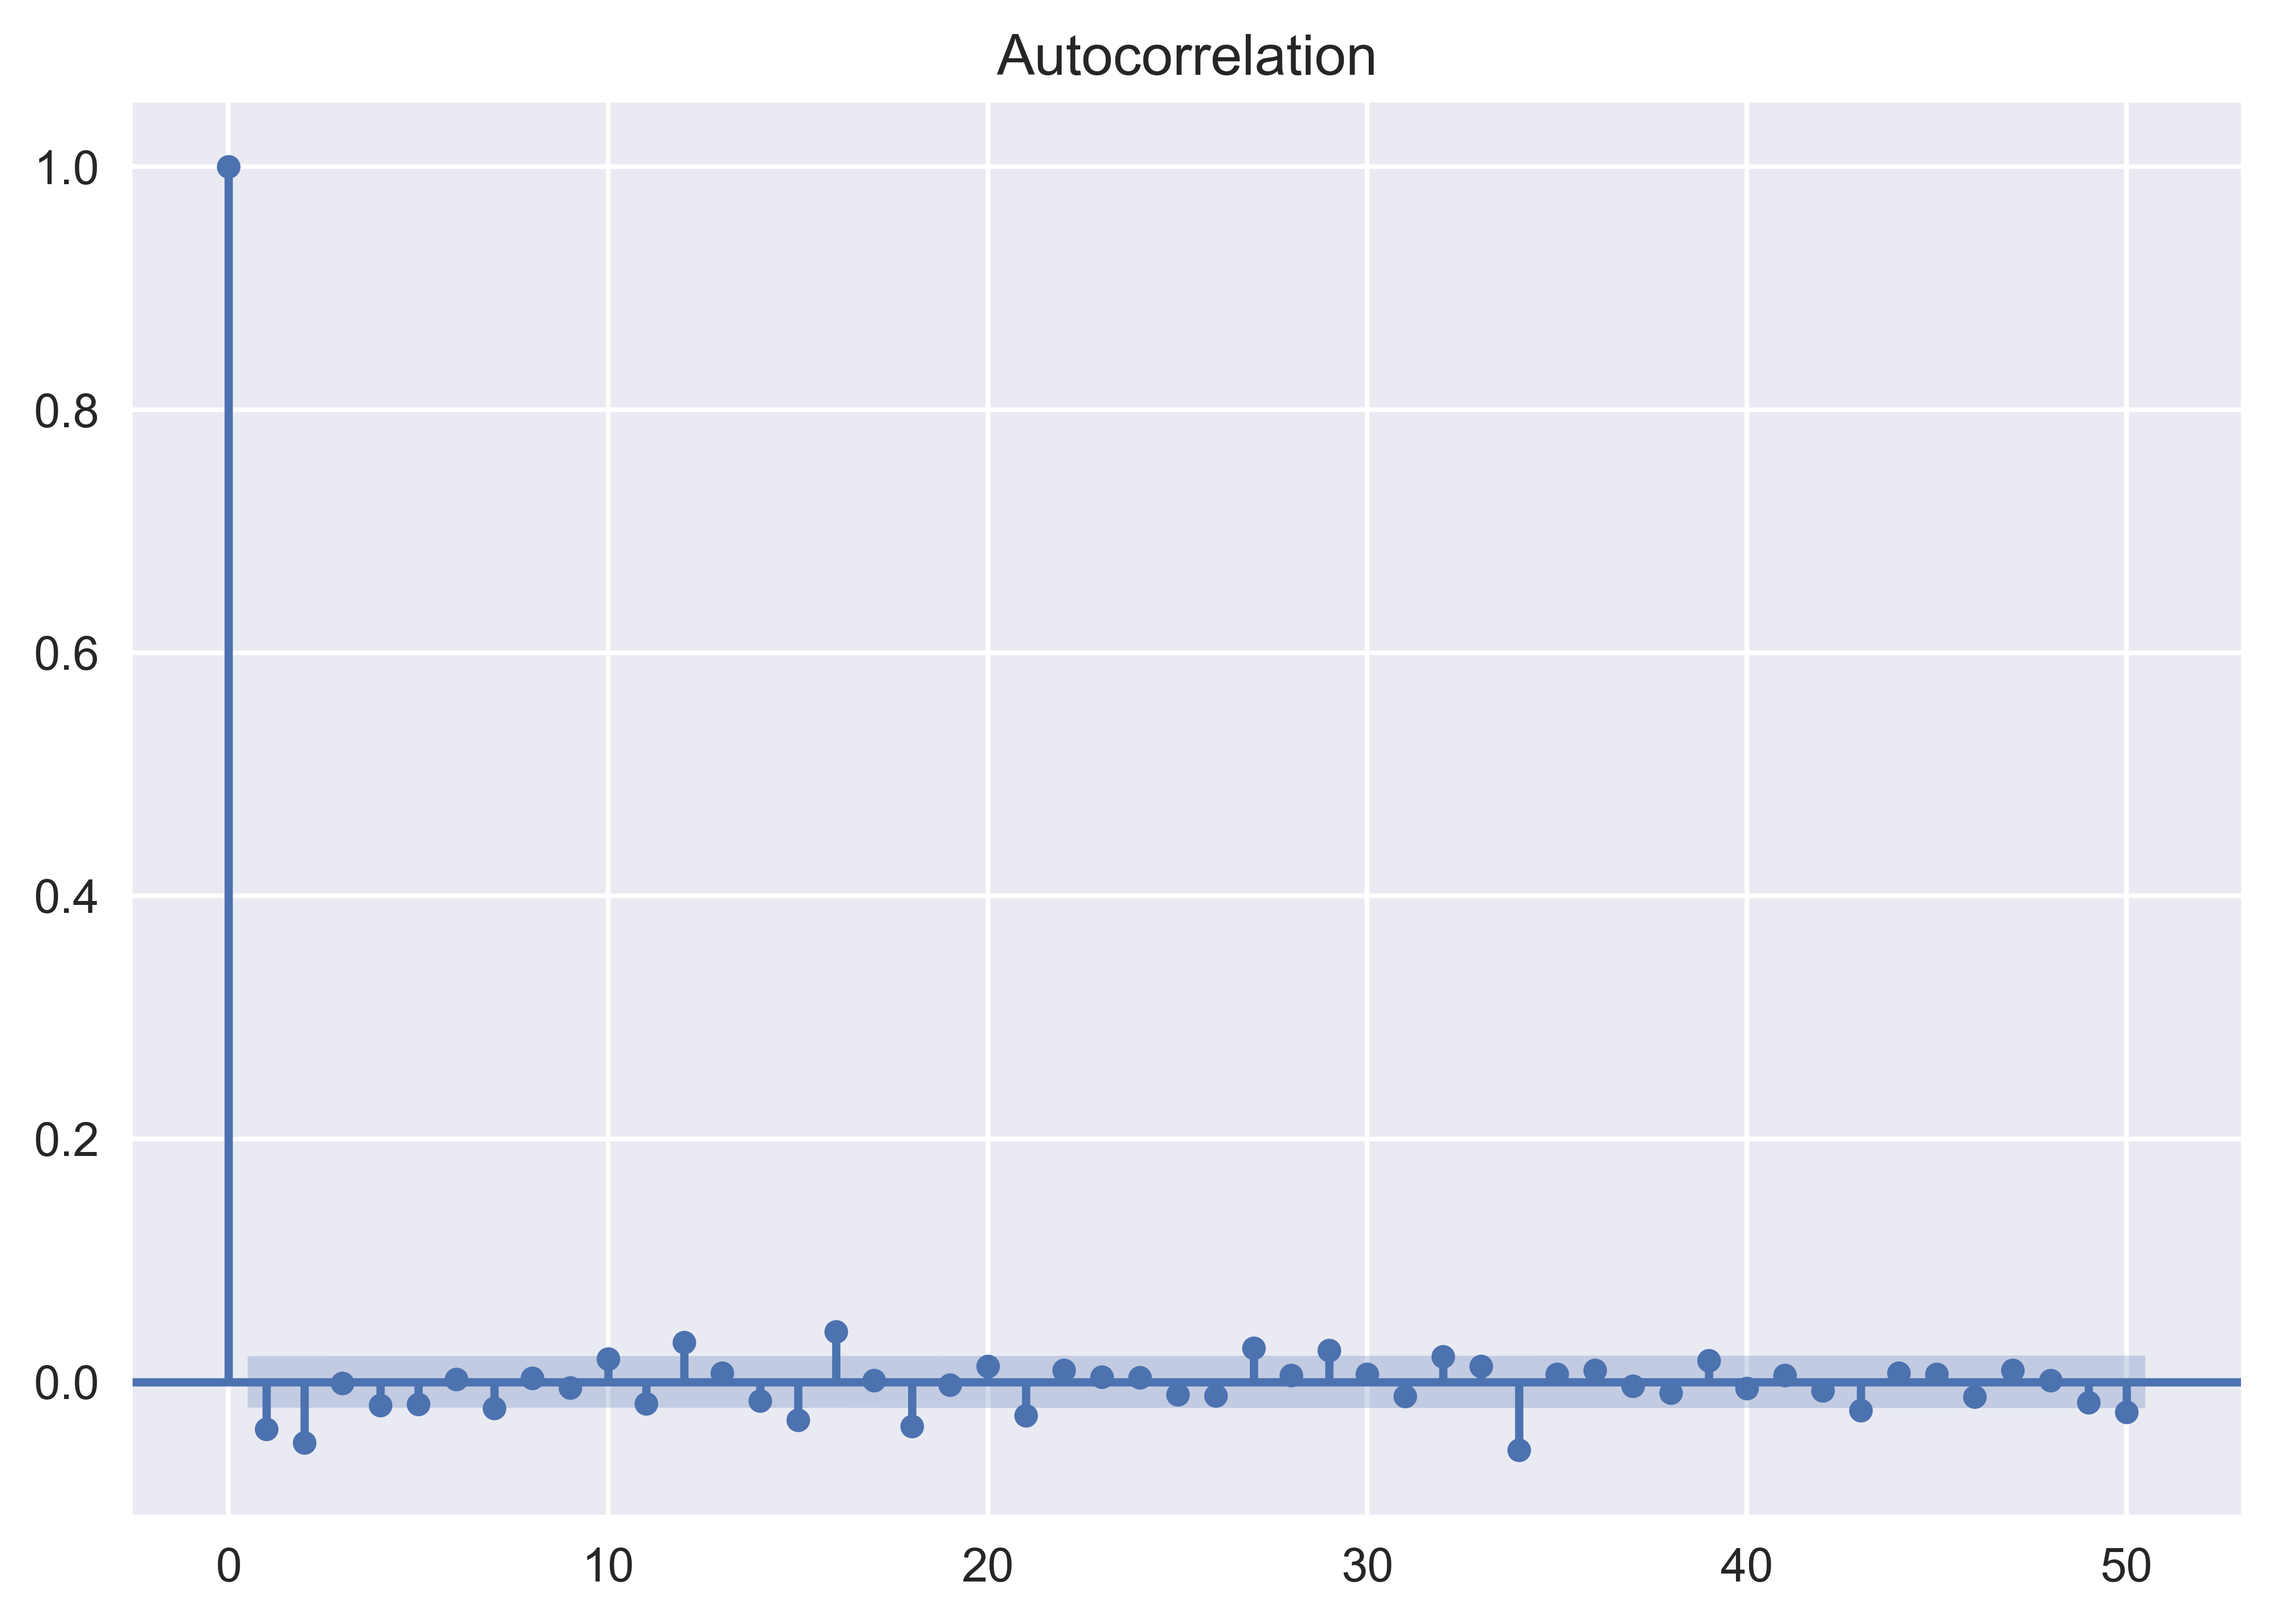

In [41]:
acf = smt.graphics.plot_acf(df.log_rtn, 
                            lags = N_LAGS,
                            alpha=SIGNIFICANCE_LEVEL)
plt.show()

#### Fact 4 - Small and decreasing autocorrelation in squared/absolute returns

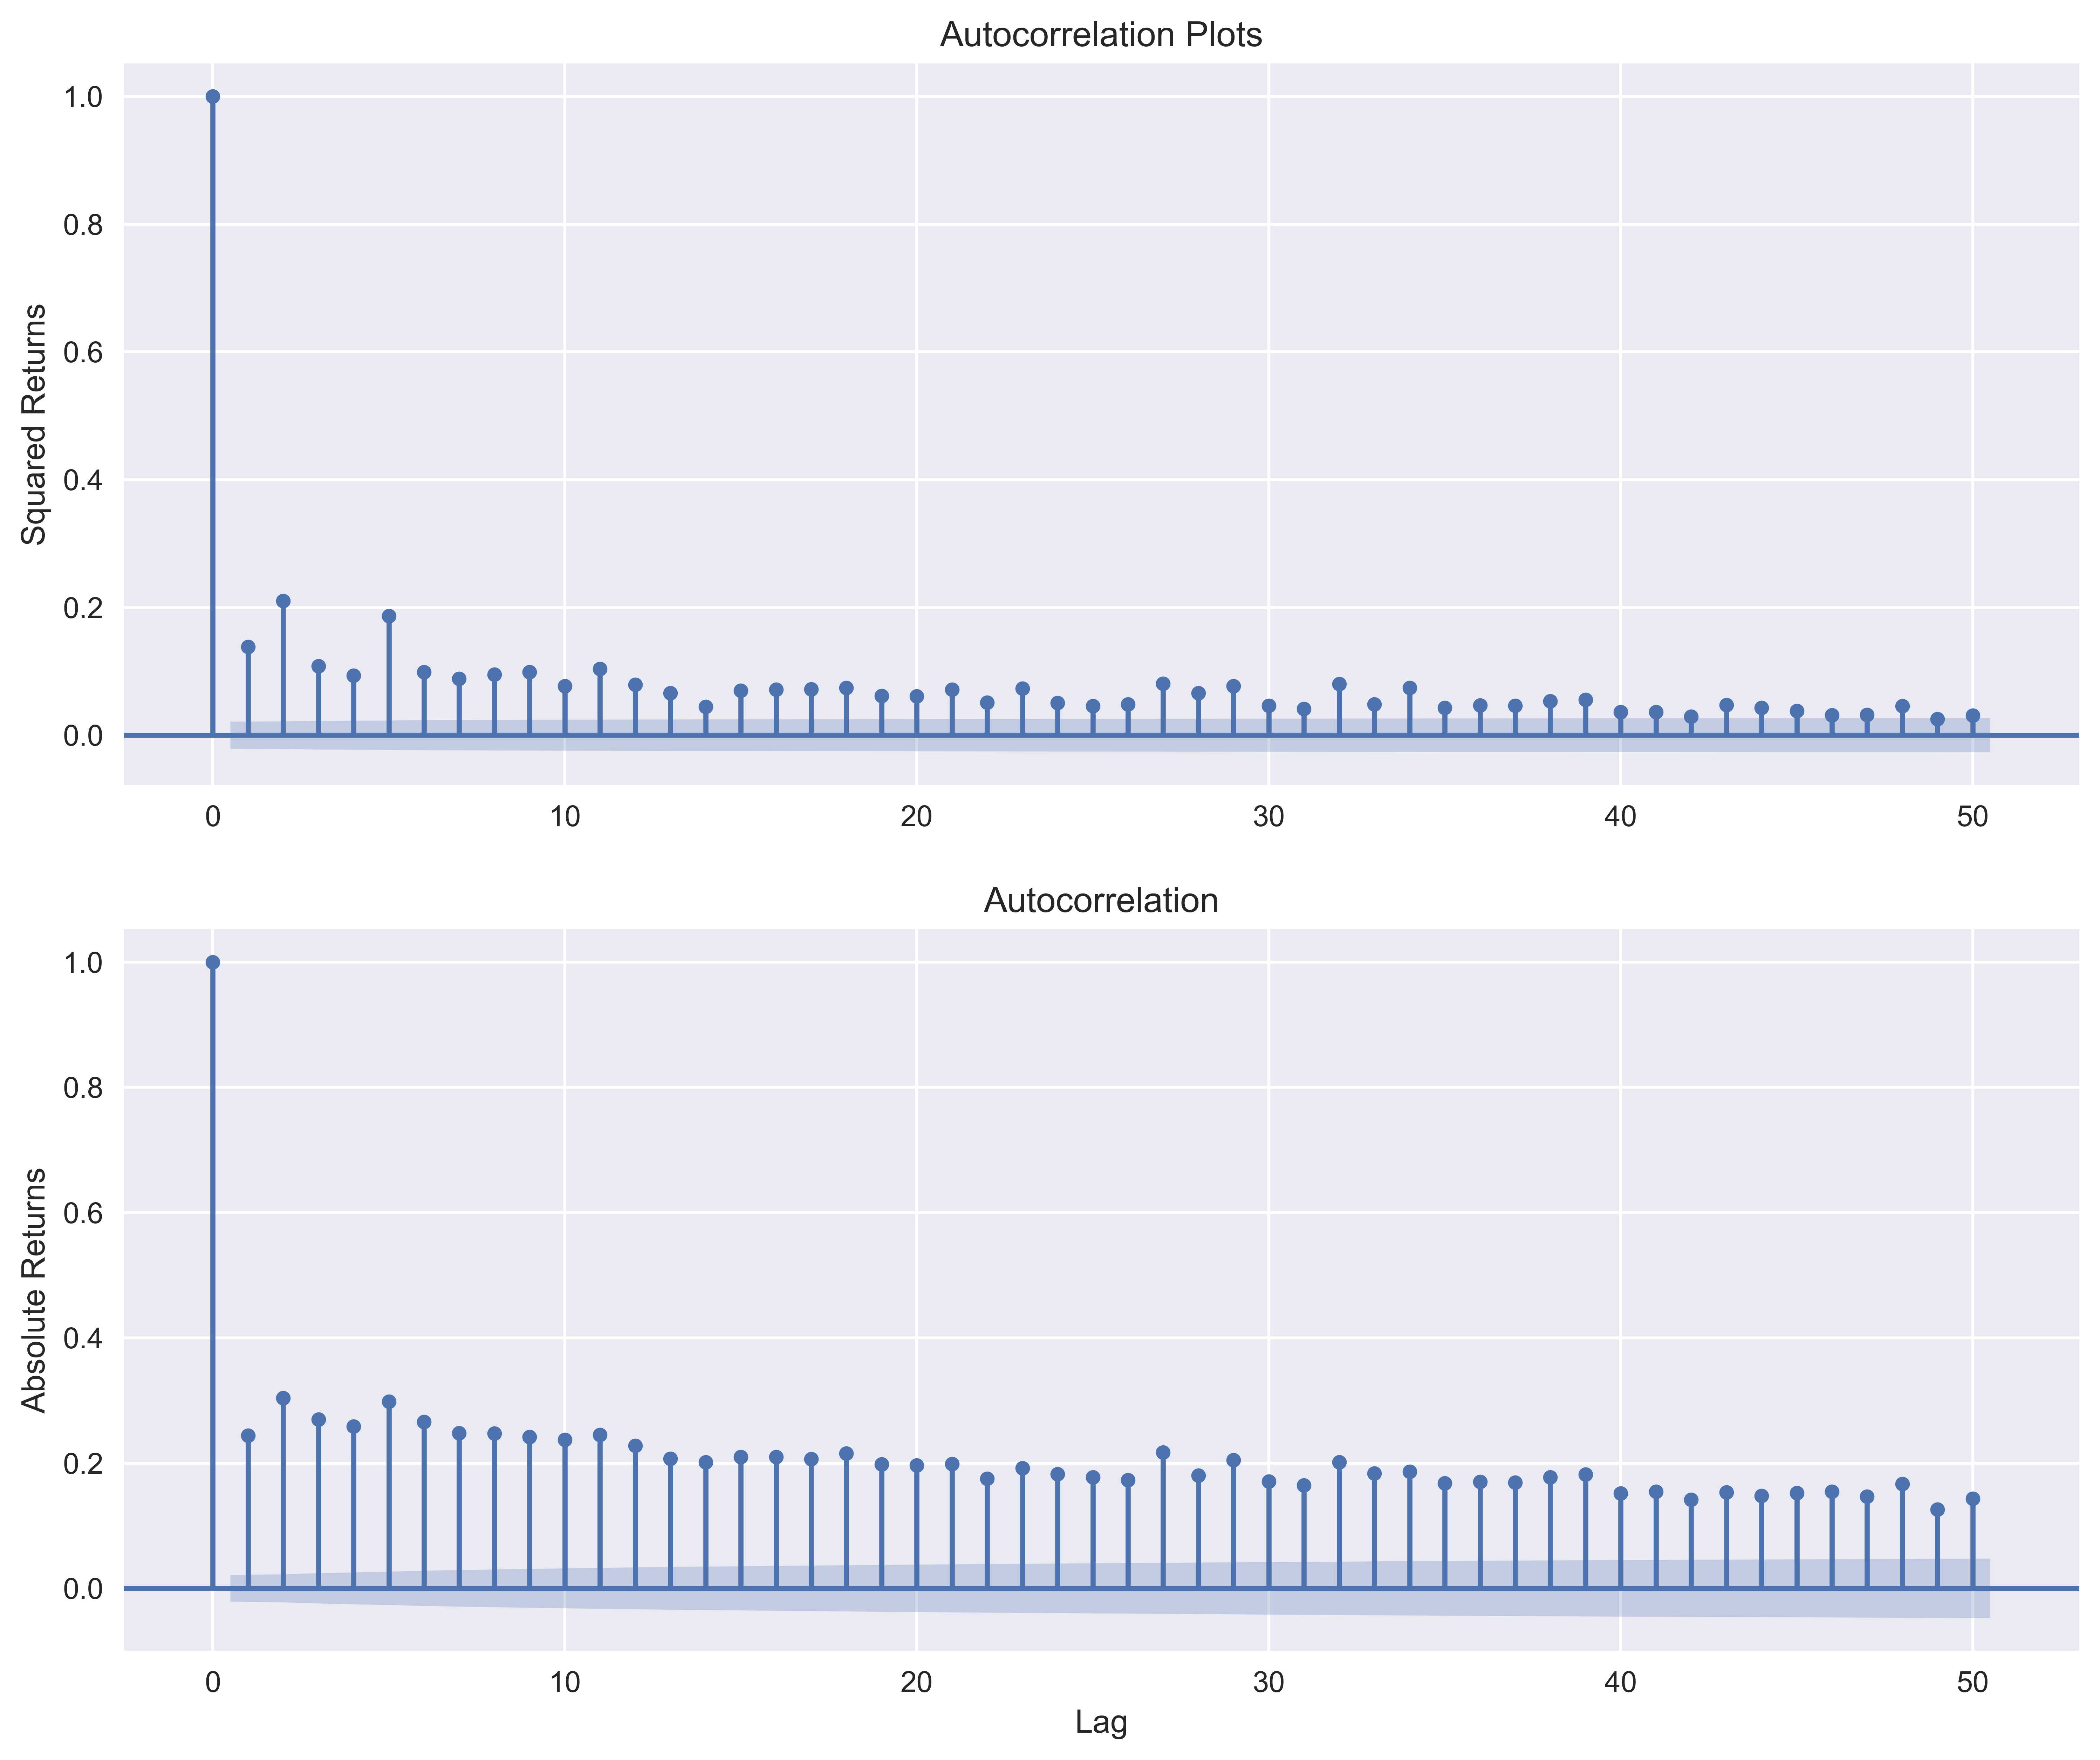

In [42]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

smt.graphics.plot_acf(df.log_rtn**2, lags = N_LAGS, 
                      alpha = SIGNIFICANCE_LEVEL, ax = ax[0])

ax[0].set(title='Autocorrelation Plots', 
          ylabel = 'Squared Returns')

smt.graphics.plot_acf(np.abs(df.log_rtn), lags = N_LAGS, 
                      alpha = SIGNIFICANCE_LEVEL, ax = ax[1])

ax[1].set(ylabel = 'Absolute Returns', 
          xlabel = 'Lag')

plt.show()


#### Fact 5 - Leverage effect

1. Calculate volatility measures as moving standard deviations

In [43]:
df['moving_std_252'] = df[['log_rtn']].rolling(window=252).std()
df['moving_std_21'] = df[['log_rtn']].rolling(window=21).std()

2. Plot all the series:

In [44]:
fig, ax = plt.subplots(3, 1, figsize=(18, 15), 
                       sharex=True)

df.adj_close.plot(ax=ax[0])
ax[0].set(title = 'S&P 500 time series', 
          ylabel = 'Price ($)')

df.log_rtn.plot(ax=ax[1])
ax[1].set(ylabel = 'Log returns (%)')

df.moving_std_252.plot(ax = ax[2], color='r', 
                       label='Moving Volatility 252d')
df.moving_std_21.plot(ax = ax[2], color='g', 
                       label='Moving Volatility 21d')
ax[2].set(ylabel='Moving Volatility', 
          xlabel = 'Date')
ax[2].legend()

plt.show()

### There's more

1. Download and preprocess the prices of S&P 500 and VIX:

In [45]:
df = yf.download(['^GSPC', '^VIX'], 
                 start = '1985-01-01', 
                 end = '2018-12-31', 
                 progress=False)
df = df[['Adj Close']]
df.columns = df.columns.droplevel(0)
df = df.rename(columns={'^GSPC': 'sp500', '^VIX': 'vix'})

2. Calculate log returns:

In [46]:
df['log_rtn'] = np.log(df.sp500 / df.sp500.shift(1))
df['vol_rtn'] = np.log(df.vix / df.vix.shift(1))
df.dropna(how='any', axis = 0, inplace = True)

3. Plot a scatterplot with the returns on the axes and fit a regression line to identify trend:

In [47]:
corr_coeff = df.log_rtn.corr(df.vol_rtn)

In [48]:
corr_coeff

-0.7126827046793579

regplot draws -> regression line 
y = a + b*x (f(x)) : (x1, y1) (x2, y2), (x3, y3), ...... (x100, y100) ... 

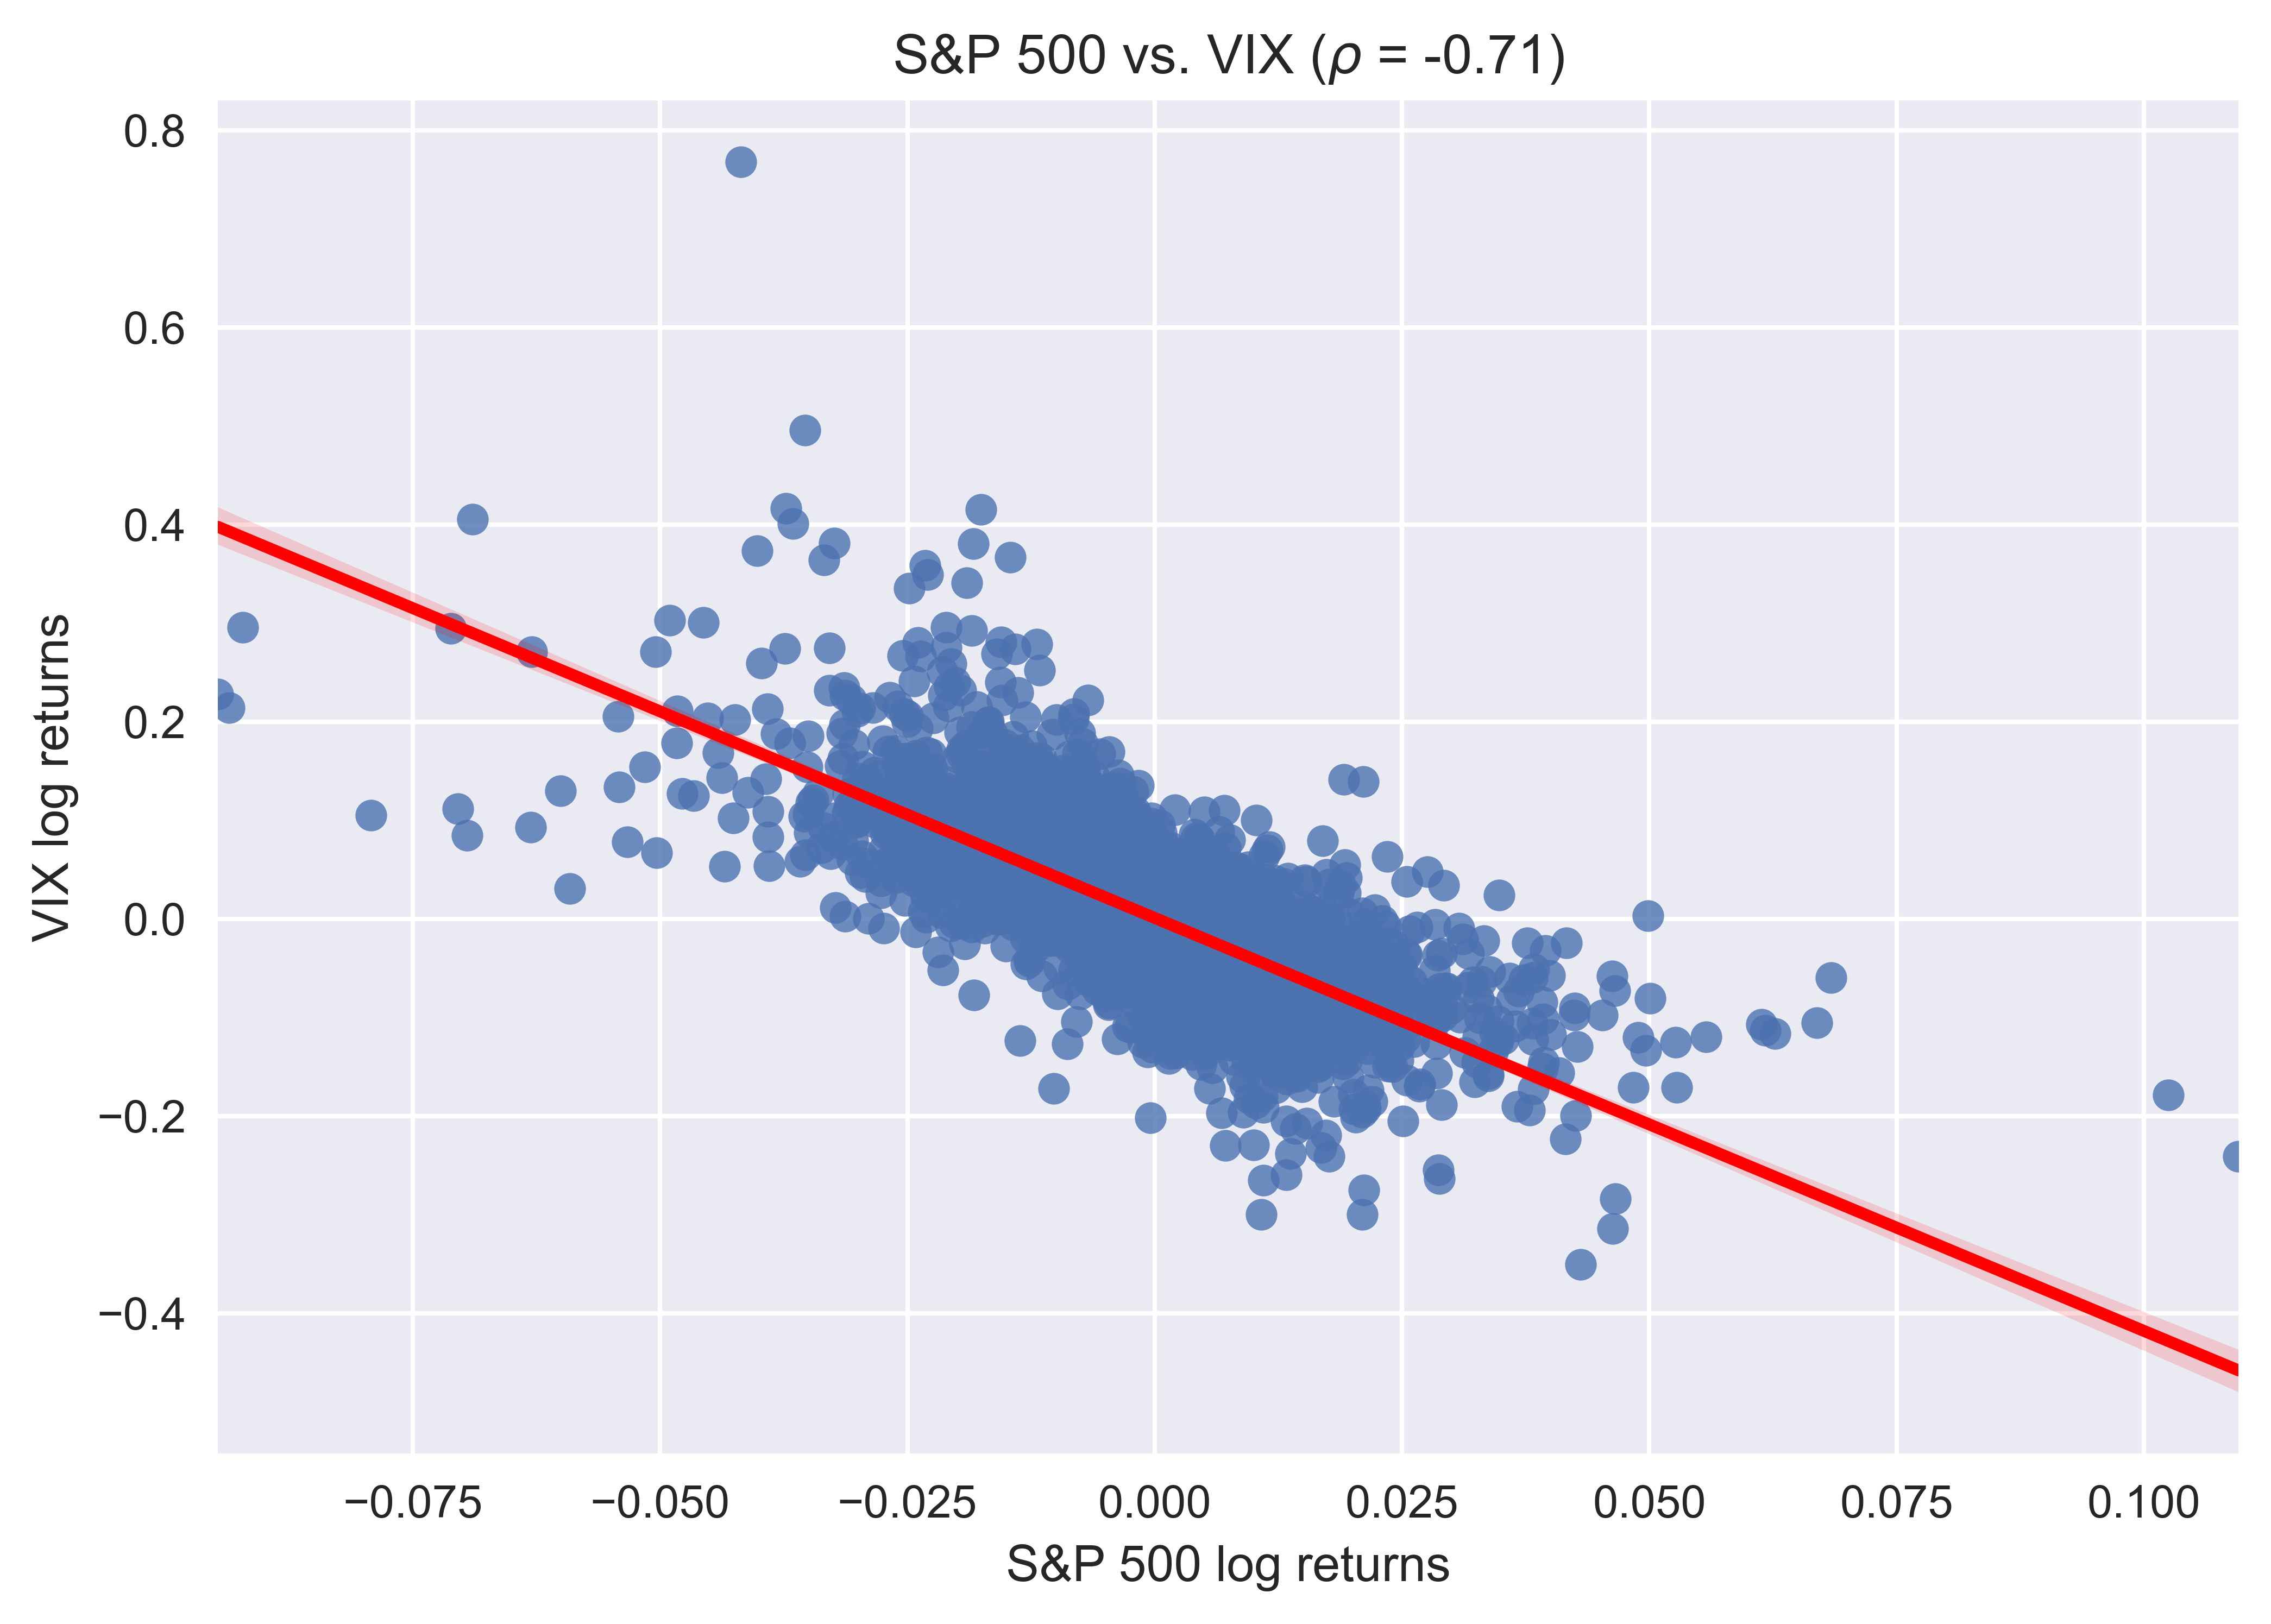

In [49]:
ax = sns.regplot(x='log_rtn', y = 'vol_rtn', data =df , 
                 line_kws={'color':'red'})

ax.set(title=f'S&P 500 vs. VIX ($\\rho$ = {corr_coeff:.2f})',
       ylabel='VIX log returns',
       xlabel='S&P 500 log returns')

plt.show()